Install keras

In [3]:
!pip3 install keras

Download data and uncompress

In [4]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

--2021-03-11 14:15:41--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2021-03-11 14:15:41--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf3038e514b22083bb9ccd5133f.dl.dropboxusercontent.com/cd/0/inline/BKeJDarngGGYkKgJc2cLhMiTSlluHQ3t3YguF62vX765ZDH_fuvV6oQN9O1xsf56V9_v_CCeqEzgORgMqU3fYZbA9iKR9IpmlsmmDf3h4DPhasG13jry_Ow17i4ph4dY_bcm39r6l_pwS-Qk4ggY4-Rt/file# [following]
--2021-03-11 14:15:42--  https://ucf3038e514b22083bb9ccd5133f.dl.dropboxusercontent.com/cd/0/inline/BKeJDarngGGYkKgJc2cLhMiTSlluHQ3t3YguF62vX765ZDH_fuvV6oQN9O1xsf56V9_v_CCeqEzgORgMqU3fYZbA9iKR9Ipm

Import packages 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Load and prepare data

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


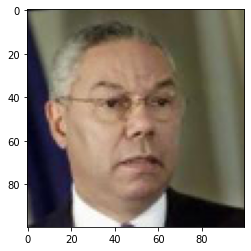

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [10]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
datagen = ImageDataGenerator(
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range = 0.25,
    horizontal_flip=True)
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


Create model, data augmentation etc... 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
gaussian_noise_18 (GaussianN (None, 100, 100, 32)      0         
_________________________________________________________________
activation_21 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 50, 50, 32)       

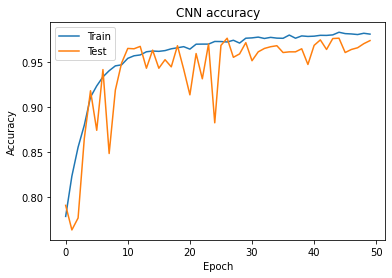

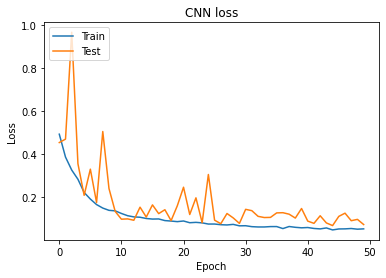

In [13]:
batch_size = 128
num_classes = 2
epochs = 50
def CBGN(model,filters,ishape=0):
    if (ishape!=0):
        model.add(Conv2D(filters, (3, 3), padding='same',input_shape=ishape))
    else:
        model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(BN())
    model.add(GN(0.1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(BN())
    model.add(GN(0.1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

  
    return model

## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,32)

model.add(Flatten())
model.add(Dense(16))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch):
    if epoch < 50:
        return .01
    elif epoch < 80:
        return 0.001
    else:
        return 0.001

set_lr = LRS(scheduler)

history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()